# Variable Coefficient Poisson

We want to solve an equation of the form $\nabla \cdot (\alpha \nabla \phi) = f$

We'll do this with periodic boundary conditions.  Consider the coefficient $\alpha$ of the form:

$$\alpha = 2 + \cos(2 \pi x) * cos(2*\pi x)$$

and the source, $f$:

$$f = -16 \pi^2 \left ( \cos(2 \pi x) \cos(2\pi y) + 1 \right ) \sin(2\pi x) \sin(2\pi y)$$

The solution to this (with periodic BCs) is:

$$\phi = \sin(2\pi x) \sin(2\pi y)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Setting up the solver

In [2]:
import pyro.multigrid.variable_coeff_MG as MG

In [3]:
def true(x, y):
    return np.sin(2.0*np.pi*x)*np.sin(2.0*np.pi*y)

In [4]:
def alpha(x, y):
    return 2.0 + np.cos(2.0*np.pi*x)*np.cos(2.0*np.pi*y)

In [5]:
def f(x, y):
    return -16.0*np.pi**2*(np.cos(2*np.pi*x)*np.cos(2*np.pi*y) + 1) * \
        np.sin(2*np.pi*x)*np.sin(2*np.pi*y)

Let's create a patch to store the coefficient $\alpha$

In [6]:
from pyro.mesh import patch
import pyro.mesh.boundary as bnd

In [7]:
N = 128

g = patch.Grid2d(N, N, ng=1)
d = patch.CellCenterData2d(g)
bc_alpha = bnd.BC(xlb="periodic", xrb="periodic",
                  ylb="periodic", yrb="periodic")
d.register_var("alpha", bc_alpha)
d.create()

Now we can fill the coefficient

In [8]:
a = d.get_var("alpha")
a[:, :] = alpha(g.x2d, g.y2d)

With periodic BCs, solvability requires that $f$ sum to zero over the domain.  Let's check that.

In [9]:
rhs = f(g.x2d, g.y2d)
print(f"rhs sum: {np.sum(rhs[g.ilo:g.ihi+1, g.jlo:g.jhi+1])}")

rhs sum: 3.406203297933244e-12


Now we can create the multigrid object

In [10]:
mg = MG.VarCoeffCCMG2d(N, N,
                       xl_BC_type="periodic", yl_BC_type="periodic",
                       xr_BC_type="periodic", yr_BC_type="periodic",
                       coeffs=a, coeffs_bc=bc_alpha,
                       verbose=1, vis=0, true_function=true)

cc data: nx = 2, ny = 2, ng = 1
         nvars = 4
         variables:
               v: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
               f: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
               r: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
          coeffs: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    

cc data: nx = 4, ny = 4, ng = 1
         nvars = 4
         variables:
               v: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: periodic     +x: periodic     -y: periodic     +y: periodic    
               f: min:    0.0000000000    max:    0.0000000000
                  BCs: -

Initialize the solution to 0

In [11]:
mg.init_zeros()

Now initialize the RHS

In [12]:
rhs = f(mg.x2d, mg.y2d)
mg.init_RHS(rhs)

Source norm =  81.38684285750472


## Solving the system

In [13]:
mg.solve(rtol=1.e-11)

source norm =  81.38684285750472
<<< beginning V-cycle (cycle 1) >>>

  level: 6, grid: 128 x 128
  before G-S, residual L2: 81.38684285750472
  after G-S, residual L2: 112.0908331315555

  level: 5, grid: 64 x 64
  before G-S, residual L2: 79.20476910530611
  after G-S, residual L2: 101.02040748025243

  level: 4, grid: 32 x 32
  before G-S, residual L2: 71.24113182887879
  after G-S, residual L2: 68.07049203593525

  level: 3, grid: 16 x 16
  before G-S, residual L2: 47.65766921623646
  after G-S, residual L2: 14.457805865685271

  level: 2, grid: 8 x 8
  before G-S, residual L2: 9.844801065610541
  after G-S, residual L2: 0.017140908875684105

  level: 1, grid: 4 x 4
  before G-S, residual L2: 0.010614107357162545
  after G-S, residual L2: 5.960897793894367e-16

  bottom solve:
  level: 0, grid: 2 x 2

  level: 1, grid: 4 x 4
  before G-S, residual L2: 1.0834180107377754e-15
  after G-S, residual L2: 5.96089897709959e-16

  level: 2, grid: 8 x 8
  before G-S, residual L2: 0.01682430

## Visualizing the solution

In [14]:
v = mg.get_solution()

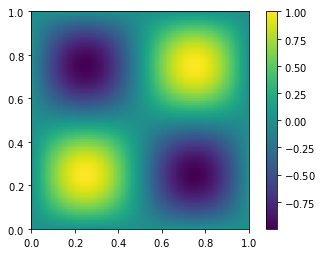

In [27]:
fig, ax = plt.subplots()

im = ax.imshow(np.transpose(v.v()),
              interpolation="nearest", origin="lower",
              extent=[mg.xmin, mg.xmax, mg.ymin, mg.ymax])
fig.colorbar(im, ax=ax)

## Comparing to the exact solution

In [16]:
phi = true(mg.x2d, mg.y2d)

With periodic BCs all around, there is nothing to normalize the solution, so we subtract off the average of $\phi$ from the MG solution to ensure it is normalized (we'll do the same with the true solution, just to be sure)

In [21]:
e = v - np.sum(v.v()) / N**2 - (phi - np.sum(phi[mg.ilo:mg.ihi+1, mg.jlo:mg.jhi+1]) / N**2)

Now we can look at the norm of the error:

In [22]:
e.norm()

9.75498468512499e-05

and we can plot the error

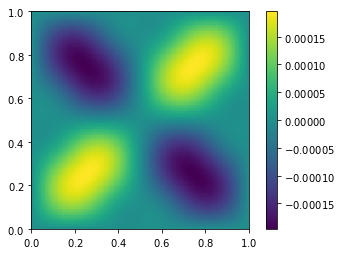

In [26]:
fig, ax = plt.subplots()

im = ax.imshow(np.transpose(e.v()),
               interpolation="nearest", origin="lower",
               extent=[mg.xmin, mg.xmax, mg.ymin, mg.ymax])
fig.colorbar(im, ax=ax)